# Assignment 1: Text classification for Fake News Detection (Part 1)

<p>
Name: Eleanor Prashamshini <br>
Student ID: 220772291 <br>
Subject: Natural Language Processing (ECS763P) <br>
</p>

## 0: Setup and Loading Data

In [1]:
!pip install nltk


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

## Question 1: Input and Basic preprocessing

In [4]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    # return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]

# Input: an individual record as a list of attributes 
def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    
    """Selects and returns the required attributes from dataset - label and statement."""
    # data_line = [Id, label, statement, subject, speaker, speaker_job_title, state_info, 
    # party_affiliation, total_barely_true_counts, total_false_counts, total_half_true_counts, 
    # total_mostly_true_counts, total_pants_on_fire_counts, context]
    
    # Output: label and statement as tuple
    return (convert_label(data_line[1]), data_line[2])

In [5]:
# testing parse_data_line()
test_1 = parse_data_line(['2635.json', 'false', 'Says the Annies List political group supports third-trimester abortions on demand.', 'abortion', 'dwayne-bohac', 'State representative', 'Texas', 'republican', 0, 1, 0, 0, 0, 'a mailer'])
print(test_1)

('FAKE', 'Says the Annies List political group supports third-trimester abortions on demand.')


In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
import string
from nltk.tokenize import word_tokenize

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    
    """Converts a statement into a bag of words."""
    # The word_tokenize() from nltk.tokenise is useful in splitting up a 
    # sentence into a list of tokens (where even punctuation is
    # separated from the beginning and end of words/numbers).
    # Filtering over the list we discard the punctuations
    
    tokens = [t for t in word_tokenize(text) if t.strip(string.punctuation) != ""]
    
    # Output: tokens as list 
    return tokens

In [8]:
# testing pre_process()
test_2 = pre_process(test_1[1])
print(test_2)

['Says', 'the', 'Annies', 'List', 'political', 'group', 'supports', 'third-trimester', 'abortions', 'on', 'demand']


## Question 2: Basic Feature Extraction

In [9]:
global_feature_dict = {} # A global dictionary of features
global_feature_count = 0 # Count of global dictionary

# Input: a list of tokens
def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    
    global global_feature_dict, global_feature_count # to ensure no local assignments are created
    
    """Converts a bag of words into a feature vector."""
    # Creating a feature vector by adding the tokens as key in
    # the feature vector and count of its occurence as value.
    # Simultaneously adding all the unique tokens to a 
    # global dictionary of features
    
    feature_vector = {}  # local feature vector
    for token in tokens:
        
        # Checking if the token exists as feature and increasing its count 
        # otherwise adding the token to feature vector and setting its count to 1
        if token in feature_vector.keys():
            feature_vector[token] +=1
        else:
            feature_vector[token] = 1
            
        # Adding token to the global_feature_dict if it doesn't already exist as key 
        if token not in global_feature_dict.keys():
            global_feature_count += 1 # incrementally adding keys
            global_feature_dict[token] = global_feature_count
            
    # Output: feature vector as dict
    return feature_vector

In [10]:
# testing to_feature_vector()
test_3 = to_feature_vector(test_2)
print("feature vector:", test_3)

# NOTE: The testing does not affect the overall global_feature_dict because we are using the first line in dataset
print("\nglobal features:", global_feature_dict) 

feature vector: {'Says': 1, 'the': 1, 'Annies': 1, 'List': 1, 'political': 1, 'group': 1, 'supports': 1, 'third-trimester': 1, 'abortions': 1, 'on': 1, 'demand': 1}

global features: {'Says': 1, 'the': 2, 'Annies': 3, 'List': 4, 'political': 5, 'group': 6, 'supports': 7, 'third-trimester': 8, 'abortions': 9, 'on': 10, 'demand': 11}


In [11]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(random_state=1))]) # setting a random_state to ensure consistent results
    return SklearnClassifier(pipeline).train(data)

## Question 3: Cross-validation on Training Data

In [12]:
# Input:
# dataset - the data to be divided
# held_out_start - starting index of held-out data
# held_out_end - ending index of held-out data
def split_dataset_into_train_and_held_out(dataset, held_out_start, held_out_end):
    """Splits dataset into training and held-out dataset."""
    # Using a window that starts at held_out_start and ends at held_out_end
    # we reserve some of the data for testing and the rest of it is used to 
    # create training dataset
    
    training_data = dataset[0:held_out_start] + dataset[held_out_end:len(dataset)] # training data
        
    held_out_data = [] # held-out data for testing
    held_out_labels = [] # labels of held-out data for comparison and report generation
    for s,l in dataset[held_out_start:held_out_end]:
        held_out_data.append(s) # adding statement
        held_out_labels.append(l) # adding label
    
    # Output: training data, held-out statements and held-out labels as a tuple
    return (training_data, held_out_data, held_out_labels)

In [13]:
labels = ['FAKE', 'REAL'] # classification labels

# Input: 
# training_data - the data for training classifier
# testing_data - the statements to test the classifer 
# testing_labels - the actual labels of the testing_data
def classifier_results(training_data, testing_data, testing_labels):
    """Trains, tests and generates results for classifier."""
    # The classifier is trained with the training_data and tested with the testing_data
    # An overall report is generated comparing the predictions against the testing_labels
    
    classifier = train_classifier(training_data) # training classifier
    predicted_labels = predict_labels(testing_data, classifier) # predicting labels with trained classifier
    
    # generating results in classification report
    result_metrics = classification_report(testing_labels, predicted_labels, output_dict=True, labels=labels)

    # Output: results as dict
    return result_metrics

In [14]:
# Input: 
# cv_results - variable used to store the average classification report
# kresult - classification report of one fold
# folds - number of folds
def avg_classification_report(cv_results, kresult, folds):
    """Averages the classification report across k-folds."""
    # Creates the average report by adding the fold result 
    # divided by number of folds
    # Idea if avg(b, c) = (b + c) / 2 = (b/2) + (c/2) 
    
    if len(cv_results) == 0:
        #for first iteration we only assign
        cv_results = {'accuracy': kresult['accuracy'] / folds} # accuracy is calculated overall
        del kresult['accuracy'] # to avoid confusion in adding the other results
        for l in kresult.keys(): 
            # precision, recall, f1-score are calculated for 'FAKE' and 'REAL' individually 
            # and then averaged both macro level and weighted as well
            cv_results[l] = {}
            for m in kresult[l].keys():
                cv_results[l][m] = kresult[l][m] / folds
    else:
        #for following iterations we repeat the above steps but adding instead of assigning
        cv_results['accuracy'] += kresult['accuracy'] / folds
        del kresult['accuracy']
        for l in kresult.keys():
            for m in kresult[l].keys():
                cv_results[l][m] += (kresult[l][m] / folds)
                
    # Output: updated cv_results
    return cv_results

In [15]:
#solution
from sklearn.metrics import classification_report

# Input:
# dataset - collection of feature vectors used in development
# folds - number of folds for cross validation
def cross_validate(dataset, folds):
    """Implements k-fold cross validation and generates the average classification report."""
    # Dividing the development dataset into training and held-out datasets used in 
    # training and testing the classifer. This is repeated k times by sliding the 
    # window (fold_size) across the entire dataset.
    # The final metrics are computed by averaging metric results across all the folds
    
    cv_results = {} # variable to save the average classification report
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        
        # splitting the data into fold and non-fold data
        non_fold_data, fold_data, fold_labels = split_dataset_into_train_and_held_out(dataset, i, i+fold_size)
        
        # generating metrics to evaluate the classifier
        kresult = classifier_results(non_fold_data, fold_data, fold_labels)
        
        # updating the cv_results 
        cv_results = avg_classification_report(cv_results, kresult, folds)        
    
    # Output: average classification report as dict  
    return cv_results

In [16]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [17]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
15069


In [18]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


{'accuracy': 0.5608278265048661,
 'FAKE': {'precision': 0.49519436977084913,
  'recall': 0.49166559425769696,
  'f1-score': 0.4931329315127195,
  'support': 356.20000000000005},
 'REAL': {'precision': 0.6106055679594312,
  'recall': 0.61395472603527,
  'f1-score': 0.6120513424446258,
  'support': 463.0},
 'macro avg': {'precision': 0.5528999688651401,
  'recall': 0.5528101601464834,
  'f1-score': 0.5525921369786726,
  'support': 819.2},
 'weighted avg': {'precision': 0.5611556680493185,
  'recall': 0.5608278265048661,
  'f1-score': 0.5607315346427567,
  'support': 819.2}}

## Question 4: Error Analysis 

In [19]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix."""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

In [20]:
def writing_misclassified_results(actual_labels, predicted_labels, labels):
    """Prints misclassified labels to files"""
    # The function iterates through the predicted and actual labels comparing 
    # both of them and if there is a misclassified sample it is printed to 
    # either the false_positive.txt file (predicted = FAKE, actual = REAL)
    # or the false_negative.txt file (predicted = REAL, actual = FAKE)
    
    # creating/opening the files and assigning a file object for the same
    fp = open("false_positive.txt", "w") 
    fn = open("false_negative.txt", "w") 
    
    if len(actual_labels) == len(predicted_labels):
        for i in range(0, len(actual_labels)):
            
            # false positive
            if predicted_labels[i] == labels[0] and actual_labels[i] == labels[1]:
                fp.write(raw_data[i][0] + "\n")
                # Using raw_data for displaying the strings because 
                # the initial train_set is taken from the beginning and
                # the validation set is taken from the beginning.
                # Thus the indexes align for the labels
                
            # false negative
            if predicted_labels[i] == labels[1] and actual_labels[i] == labels[0]:
                fn.write(raw_data[i][0] + "\n")
    else:
        # printing error to files
        fp.write("Number of actual labels is not equal to number of predicted labels")
        fn.write("Number of actual labels is not equal to number of predicted labels")
        
    # closing the files
    fp.close()
    fn.close()

In [21]:
# Input: 
# training_data - the data for training classifier
# testing_data - the statements to test the classifer 
# testing_labels - the actual labels of the testing_data
def classifier_results_heatmap(training_data, testing_data, testing_labels, print_misclassified=False):
    """Trains, tests and displays a confusion matrix of the predicted and actual labels."""
    # The classifier is trained with the training_data and tested with the testing_data
    # An overall report is generated comparing the predictions against the testing_labels
    # If print_misclassified is set to True, the misclassified labels (false positives and 
    # false negatives) are written to respective files
    
    classifier = train_classifier(training_data) # training classifier
    predicted_labels = predict_labels(testing_data, classifier) # predicting labels with trained classifier

    # displays confusion matrix as a heat map
    confusion_matrix_heatmap(testing_labels, predicted_labels, labels)
    
    if print_misclassified == True:
        # prints missclassified data to files
        writing_misclassified_results(testing_labels, predicted_labels, labels)

In [22]:
# Input:
# dataset - collection of feature vectors used in development
# folds - number of folds for cross validation
def cross_validate_heatmap(dataset, folds):
    """Implements k-fold cross validation and generates the average classification report."""
    # Dividing the development dataset into training and held-out datasets used in 
    # training and testing the classifer. This is repeated k times by sliding the 
    # window (fold_size) across the entire dataset and displaying the confusion matrix
    
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))
        if i == 0:
            # splitting the data into fold and non-fold data
            non_fold_data, fold_data, fold_labels = split_dataset_into_train_and_held_out(dataset, i, i+fold_size)

            # displaying confusion metric and printing false positive and false negatives to files
            classifier_results_heatmap(non_fold_data, fold_data, fold_labels, print_misclassified=True)
            
        else:        
            # splitting the data into fold and non-fold data
            non_fold_data, fold_data, fold_labels = split_dataset_into_train_and_held_out(dataset, i, i+fold_size)

            # displaying confusion metric for each fold
            classifier_results_heatmap(non_fold_data, fold_data, fold_labels)

Fold start on items 0 - 820
Training Classifier...


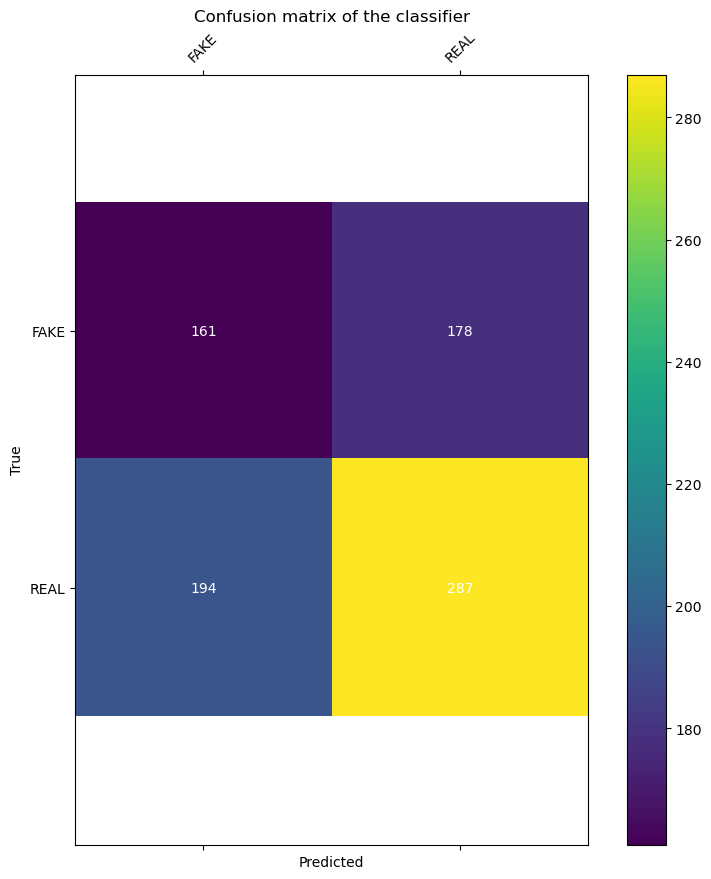

Fold start on items 820 - 1640
Training Classifier...


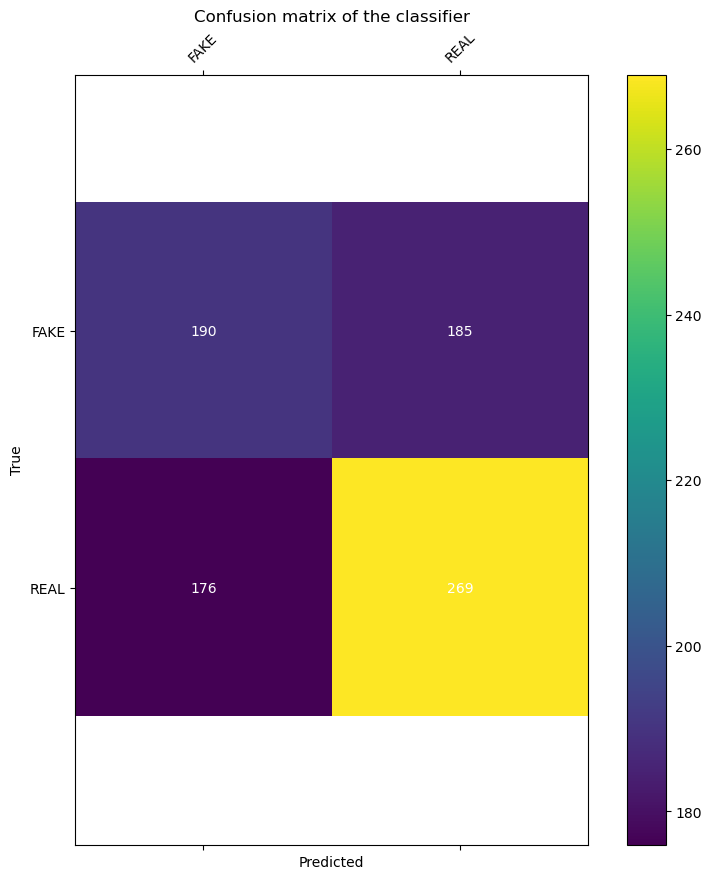

Fold start on items 1640 - 2460
Training Classifier...


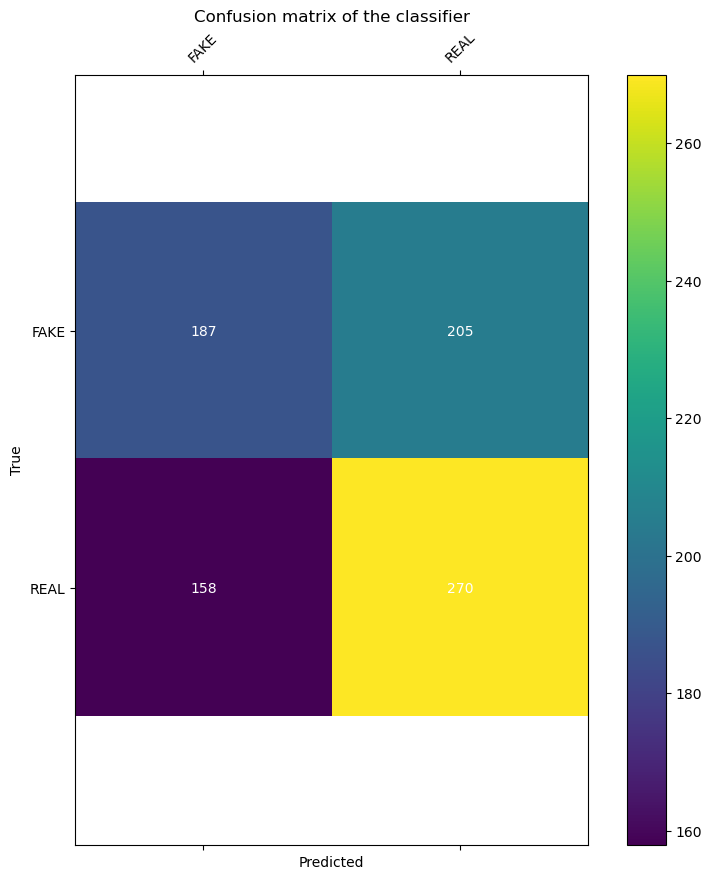

Fold start on items 2460 - 3280
Training Classifier...


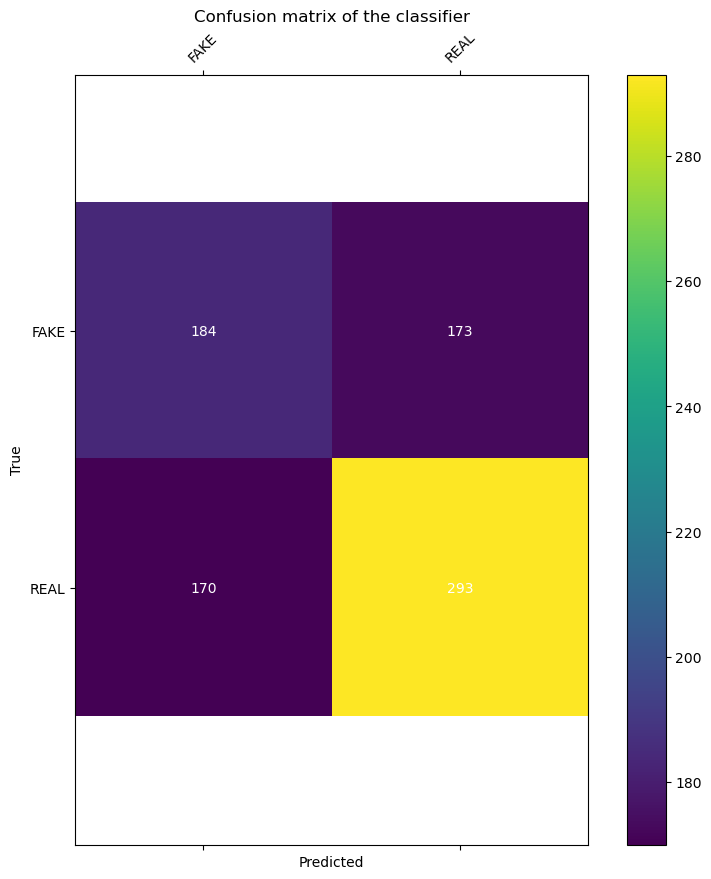

Fold start on items 3280 - 4100
Training Classifier...


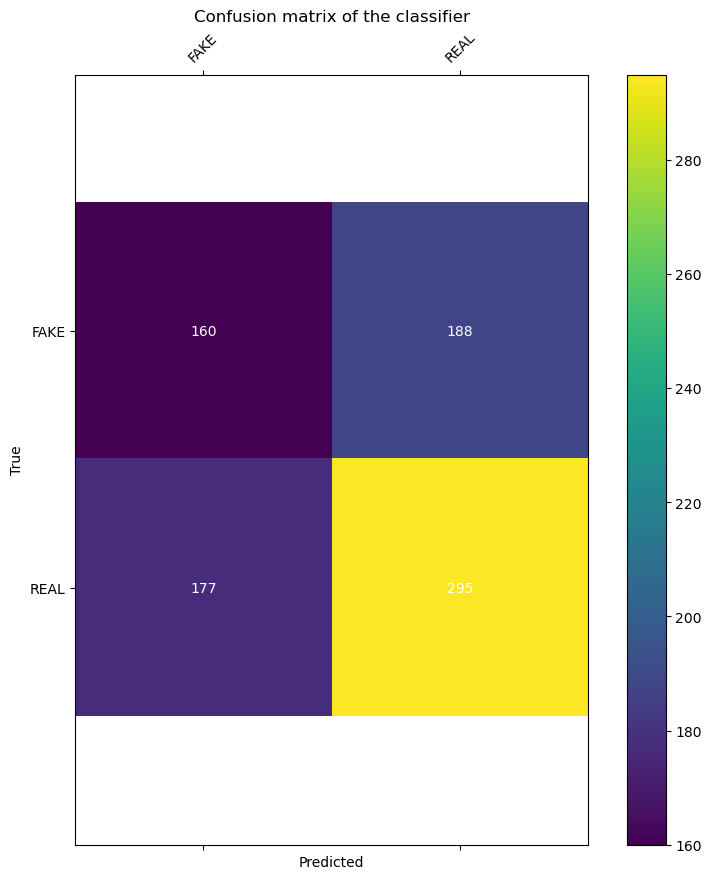

Fold start on items 4100 - 4920
Training Classifier...


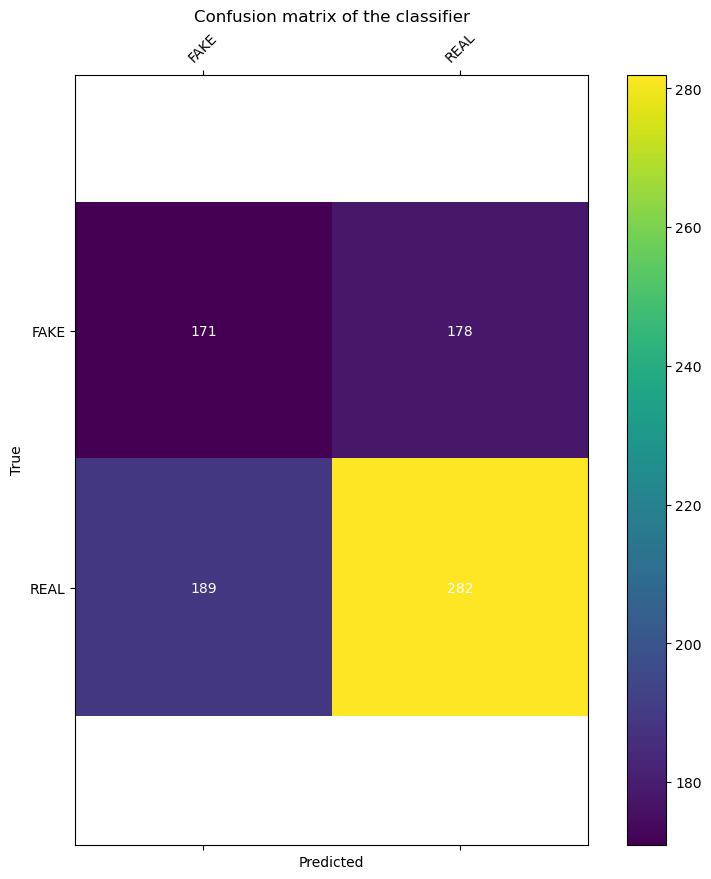

Fold start on items 4920 - 5740
Training Classifier...


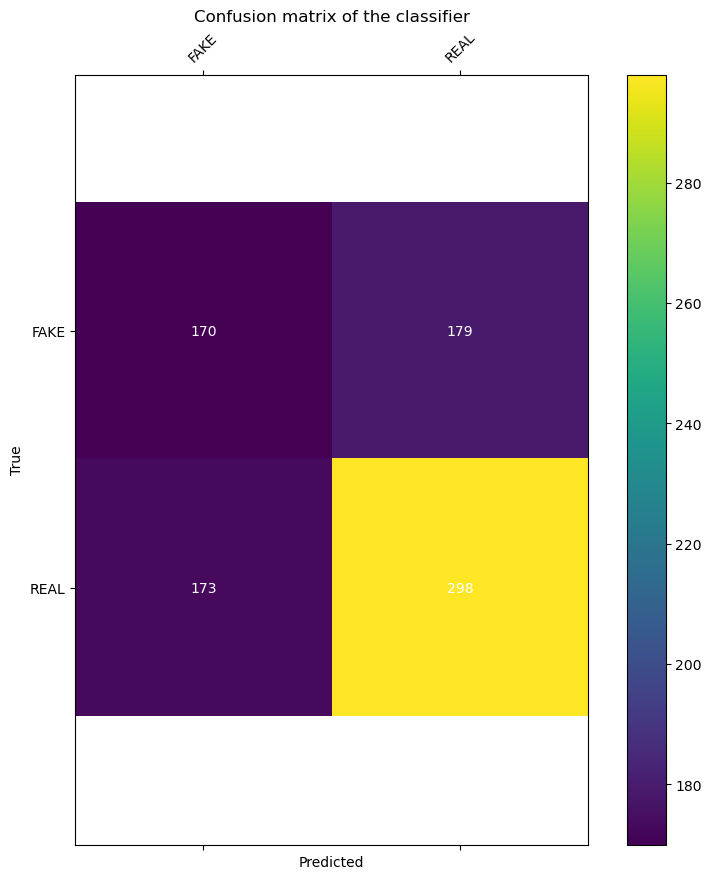

Fold start on items 5740 - 6560
Training Classifier...


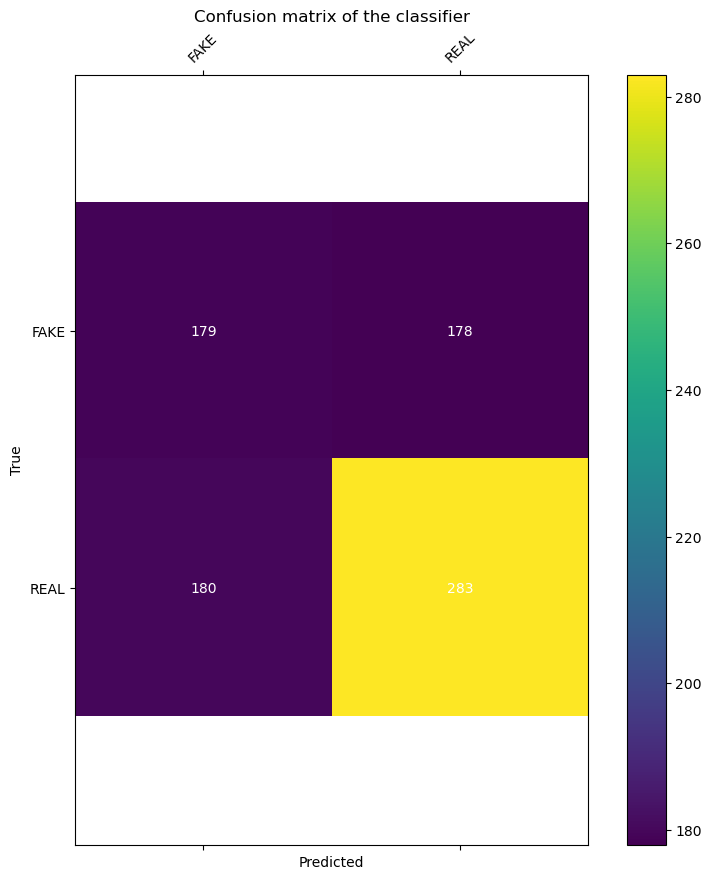

Fold start on items 6560 - 7380
Training Classifier...


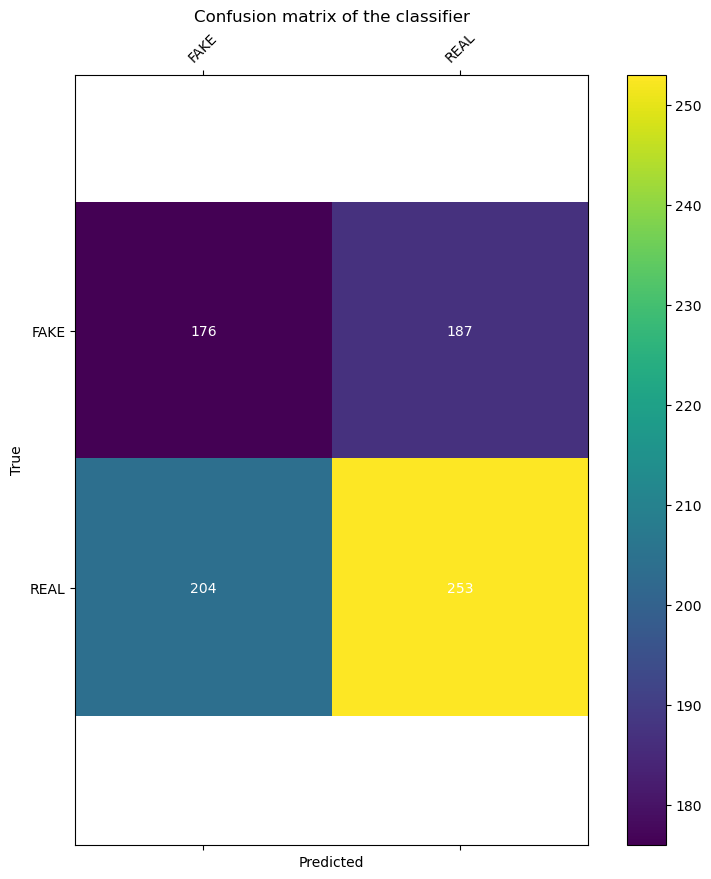

Fold start on items 7380 - 8200
Training Classifier...


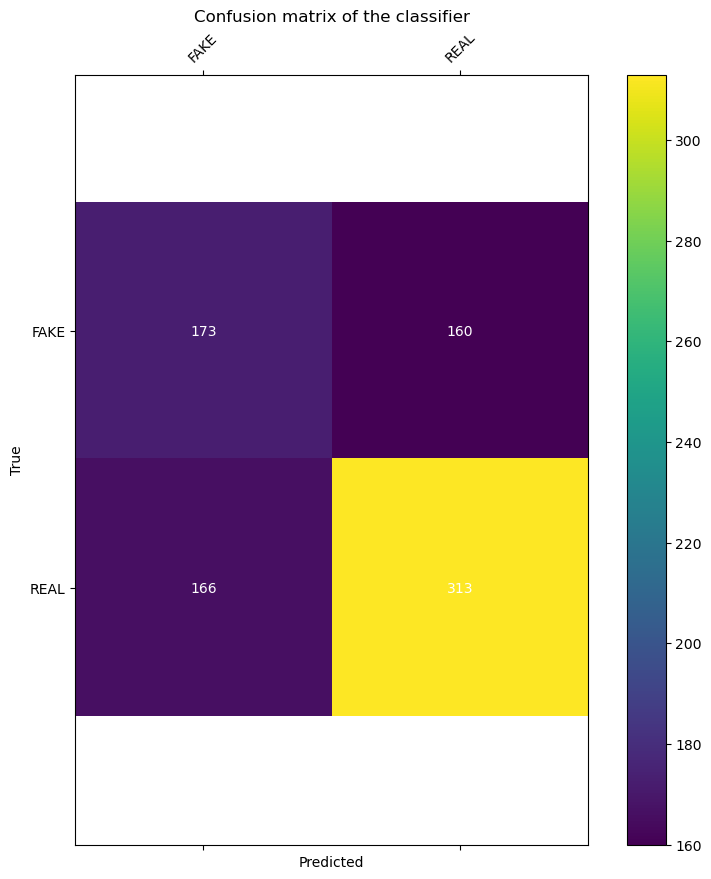

In [23]:
cross_validate_heatmap(train_data, 10)  # will work and output confusion matrix heat map for every fold

## Questions 5: Optimising Pre-processing and Feature Extraction

Contd. in Part 2 notebook

## Question 6: Using Metadata in the File -

Contd. in Part 3 notebook

## 7: Final Test

functions_complete set to True in the FINAL notebook

In [24]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = False  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])